# Segmentación de Lunares usando Image Processing

Esqueleto para la tarea T04.


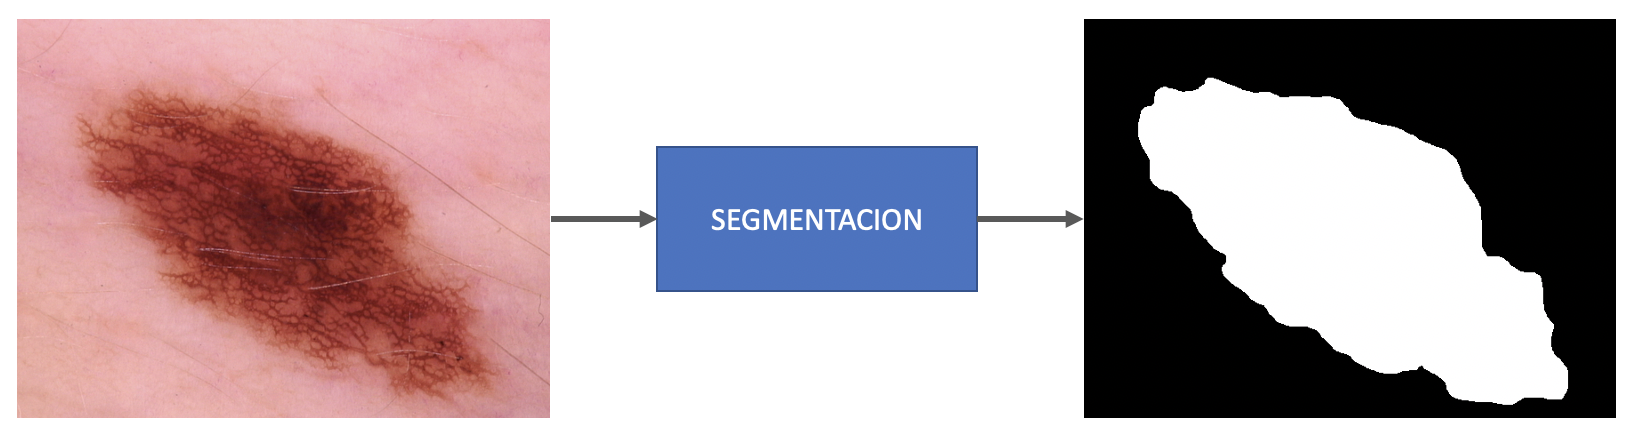

# Descarga de datos

Se descarga las imágenes a color en la carpeta `skin/color` y la segmentación manual en la carpeta `skin/seg`.

In [ ]:
!wget https://www.dropbox.com/scl/fi/g6e5lofrcpr8uffejdzrz/skinseg20.zip?rlkey=oaxneuexarped2axtq0gds2d0
!mv skinseg20.zip?rlkey=oaxneuexarped2axtq0gds2d0 skinseg20.zip
!unzip -qq skinseg20.zip

--2024-11-23 21:24:34--  https://www.dropbox.com/scl/fi/g6e5lofrcpr8uffejdzrz/skinseg20.zip?rlkey=oaxneuexarped2axtq0gds2d0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc20a5204e6bcfe4414deb9c5a4f.dl.dropboxusercontent.com/cd/0/inline/Ce943heJK4XpxCZYOArhNZDjaC6vKdgJYsiDxrusfWp7nKhwqVyU7T2qWs6ne_zaVMjlOzbTKPg0ucJ-CEs2Zy7OOoDwJXpMERoS9Zy2fu0K56PT2PPE7D39JyPI28i65Ho/file# [following]
--2024-11-23 21:24:38--  https://uc20a5204e6bcfe4414deb9c5a4f.dl.dropboxusercontent.com/cd/0/inline/Ce943heJK4XpxCZYOArhNZDjaC6vKdgJYsiDxrusfWp7nKhwqVyU7T2qWs6ne_zaVMjlOzbTKPg0ucJ-CEs2Zy7OOoDwJXpMERoS9Zy2fu0K56PT2PPE7D39JyPI28i65Ho/file
Resolving uc20a5204e6bcfe4414deb9c5a4f.dl.dropboxusercontent.com (uc20a5204e6bcfe4414deb9c5a4f.dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:601d:15::a27d:50f
Connecting to uc

# Setup iniciales

In [ ]:
from   skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import fnmatch
import os
from   tqdm.auto import tqdm

# Funciones

In [ ]:
def regionview(img, mask):
    img_color = np.dstack((img, img, img)) # colores
    img_color = label2rgb(mask, image=img_color, bg_label=0)
    return img_color

def dirfiles(img_path, img_ext,full=False,noext=False):
    """
    Carga las imágenes
    """
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    if full:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_path+img_names[i]
    if noext:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_names[i][:-4]
    return img_names

def skin_read(st):
  """
  Indica si algo es lunar o no
  """
  sti   = 'skinseg20/color/'+st+'.jpg'
  sts   = 'skinseg20/seg/'+st+'_seg.jpg'
  Itest = cv2.cvtColor(cv2.imread(sti), cv2.COLOR_BGR2RGB)
  GT    = cv2.imread(sts)[:,:,0]>128
  return Itest,GT

def skin_show(img,GT,D):
    """
    Muestra la imagen
    """
    imgs  = regionview(img[:,:,0],D)
    f = plt.figure()
    f.add_subplot(1,4,1); plt.imshow(img); plt.axis('off'); plt.title('original')
    f.add_subplot(1,4,2); plt.imshow(GT); plt.axis('off'); plt.title('GT')
    f.add_subplot(1,4,3); plt.imshow(D,cmap="gray"); plt.axis('off'); plt.title('seg')
    f.add_subplot(1,4,4); plt.imshow(imgs); plt.axis('off'); plt.title('seg')
    plt.show()

def skin_performance(GT,D):
  """
  Calcula la precisión y el recall
  """
  TP = np.sum(np.multiply(D==1,GT==1))
  FP = np.sum(np.multiply(D==1,GT==0))
  FN = np.sum(np.multiply(D==0,GT==1))
  return TP,FP,FN


# Diseño del algoritmo de segmentación

In [ ]:
def touches_border(contour, img_shape, threshold=200):
    """
    Este código se aplica en la función skin_segmentation de abajo,
    filtra aquellas zonas que otsu detectó que tocan los bordes de la imagen si lo tocan en más pixeles que el thr.
    Esto porque sabemos que las imágenes dadas en este código no tocan los bordes.
    """
    h, w = img_shape[:2]
    count = 0
    for point in contour:
        x, y = point[0]
        if x == 0 or y == 0 or x == w - 1 or y == h - 1:
            count += 1
    return count > threshold

In [ ]:
# este código se basa en: https://stackoverflow.com/questions/52858115/how-to-remove-hair-from-skin-images-using-opencv

def skin_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # imagen en byn

# ------------------------------------------------
    # f = plt.figure()
    # f.add_subplot(1, 3, 1)
    # plt.imshow(img, cmap='gray')
    # plt.axis('off')
    # plt.title('Original')
# ------------------------------------------------

    _, otsu_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # hacemos otsu

    # creamos varias máscaras para operaciones morfológicas de erosión y dilatación que usaremos después
    kernel1 = np.ones((3, 3), np.uint8)  # erosión: quita cabellos, no todos, pues se perdía parte de i = 9 con una máscara mayor
    kernel2 = np.ones((6, 6), np.uint8)  # dilatación: devuelve de la erosión, es grande porque el algoritmo es muy restrictivo, quita mucho lunar
    kernel3 = np.ones((15, 15), np.uint8)  # erosión y dilatación: rellena completamente el lunar y genera un perímetro más homogéneo

    eroded = cv2.erode(otsu_mask, kernel1, iterations=1) # aplicamos el primer kernel
    blurred = cv2.GaussianBlur(eroded, (5, 5), 0) # suavizamos la imagen para unir segmentos disconectos del lunar

# ------------------------------------------------
    # f.add_subplot(1, 3, 2)
    # plt.imshow(blurred, cmap='gray')
    # plt.axis('off')
    # plt.title('otsu bonito')
# ------------------------------------------------

    # Encontrar contornos en la máscara de Otsu:
    contours, _ = cv2.findContours(blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None  # Si no hay contornos, retornar None

    valid_contours = [cnt for cnt in contours if not touches_border(cnt, img.shape)] # aplicamos la función de tocar bordes
    # Si no hay contornos válidos, retornar None
    if not valid_contours:
        return None

    cnt = max(valid_contours, key=cv2.contourArea) # una vez filtrados los bordes, se elige el mayor, que debería ser el lunar

    # Creamos una máscara con el contorno más grande
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    dilated = cv2.dilate(mask, kernel2, iterations=1) # Aplicamos la dilatación para restaurar la forma tras la erosión
    dilated = cv2.dilate(dilated, kernel3, iterations=1) # aplicamos otra dilatación para hacer más bonita la forma
    eroded = cv2.erode(dilated, kernel3, iterations=1) # volvemos a erosionar para restaurar la forma

# ------------------------------------------------
    # res = cv2.bitwise_and(img, img, mask=eroded)
    # f.add_subplot(1, 3, 3)
    # plt.imshow(cv2.cvtColor(res, cv2.COLOR_RGB2GRAY), cmap='gray')
    # plt.axis('off')
    # plt.title('lunar final')
    # plt.show()
# ------------------------------------------------

    final_mask = eroded > 0 # volvemos la imagen booleana

    return final_mask

Idea: mostrar la imagen solo en el canal de rojo y hacer un kernel que mida la diferencia entre cada pixel, si es mayor a 20, marcar.

# Lista de imágenes

In [ ]:
img_names = dirfiles('skinseg20/color', '*.jpg',noext=True) # warning: seg_names[i] debe ser ...
n = len(img_names)
print(f'Number of images = {n}')


Number of images = 20


# Prueba del algoritmo para una imagen

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
1123 4014 0
Precision = 0.2186
Recall    = 1.0000


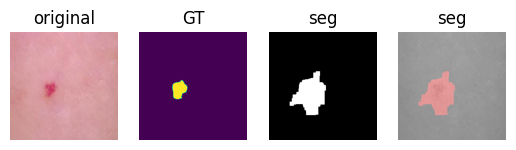

In [ ]:
i        = 1
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
print(D)
TP,FP,FN = skin_performance(GT,D)
print(TP, FP, FN)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)


Precision = 0.7109
Recall    = 1.0000


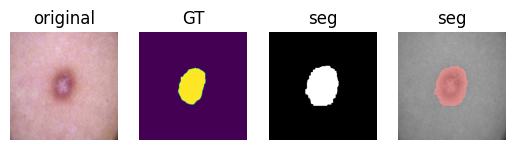

In [ ]:
i        = 2
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.5418
Recall    = 1.0000


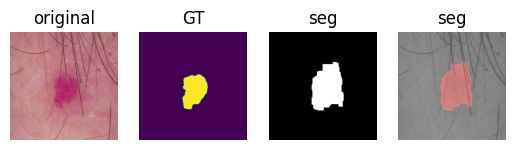

In [ ]:
i        = 3
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9996
Recall    = 0.7357


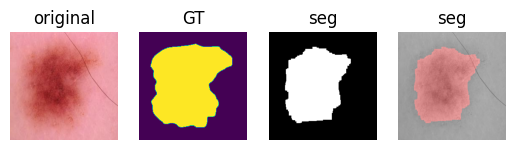

In [ ]:
i        = 4
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.8763
Recall    = 0.9956


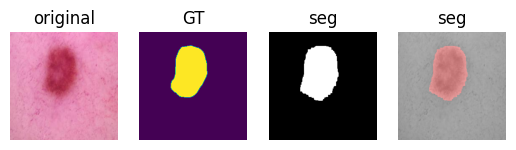

In [ ]:
i        = 5
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9322
Recall    = 0.9785


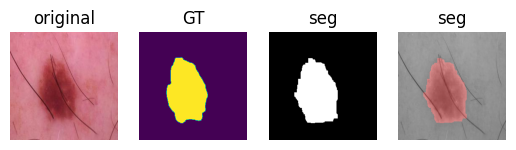

In [ ]:
i        = 6
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.8981
Recall    = 0.8449


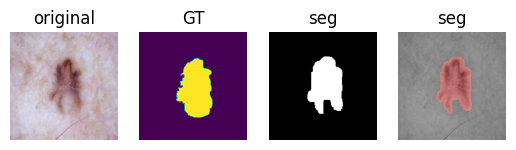

In [ ]:
i        = 7
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9222
Recall    = 0.9452


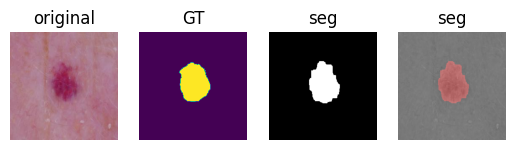

In [ ]:
i        = 8
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9933
Recall    = 0.8494


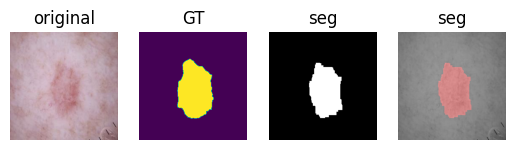

In [ ]:
i        = 9
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9937
Recall    = 0.6167


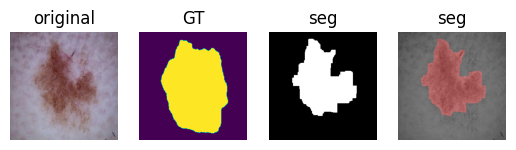

In [ ]:
i        = 10
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9205
Recall    = 0.9654


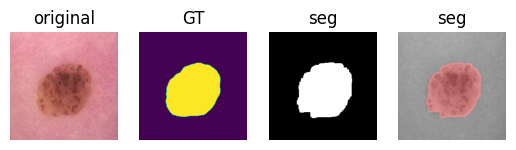

In [ ]:
i        = 11
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9566
Recall    = 0.9358


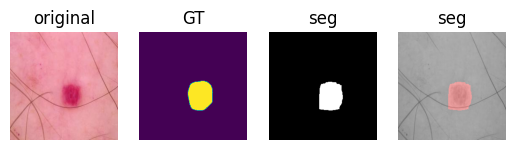

In [ ]:
i        = 12
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9382
Recall    = 0.9915


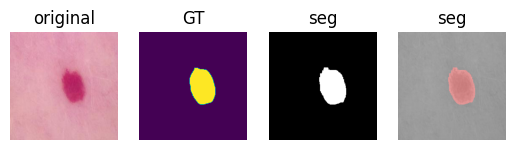

In [ ]:
i        = 13
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 1.0000
Recall    = 0.5618


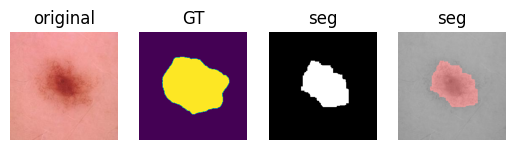

In [ ]:
i        = 14
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9267
Recall    = 0.9259


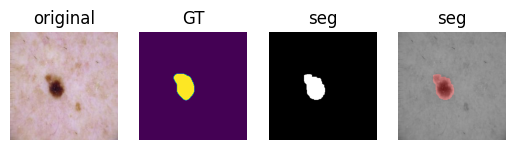

In [ ]:
i        = 15
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9753
Recall    = 0.7898


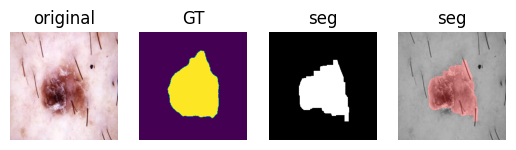

In [ ]:
i        = 16
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9427
Recall    = 0.9906


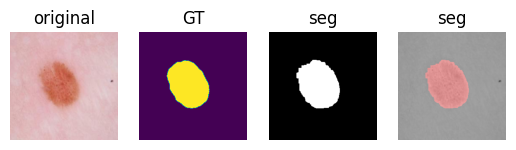

In [ ]:
i        = 17
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9125
Recall    = 0.9981


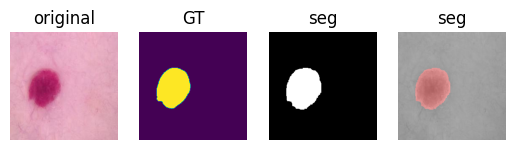

In [ ]:
i        = 18
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.9855
Recall    = 0.8952


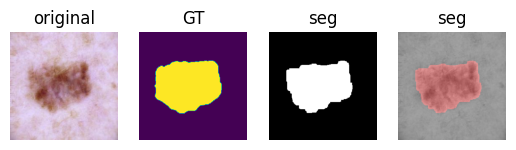

In [ ]:
i        = 19
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

Precision = 0.7925
Recall    = 0.9984


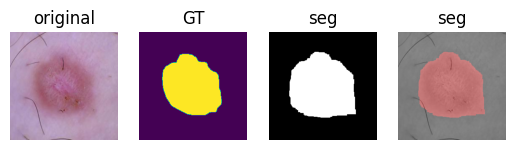

In [ ]:
i        = 0
st       = img_names[i] # prueba en la imagen i
Itest,GT = skin_read(st)
D        = skin_segmentation(Itest)
TP,FP,FN = skin_performance(GT,D)
Pr       = TP/(TP+FP)
Re       = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')
skin_show(Itest,GT,D)

# Medición de desempeño

In [ ]:
TP = 0
FP = 0
FN = 0
for i in tqdm(range(n)):
  st          = img_names[i]
  Itest,GT    = skin_read(st)
  D           = skin_segmentation(Itest)
  TPi,FPi,FNi = skin_performance(GT,D)
  TP          = TP+TPi
  FP          = FP+FPi
  FN          = FN+FNi
Pr = TP/(TP+FP)
Re = TP/(TP+FN)
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Precision = 0.8971
Recall    = 0.8381
